<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab4/blob/main/NU/Lab4_Alpha_range.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab4 Nuclear Experiment. Alpha range

Evgeny Kolonsky

v.0.1.8

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

Set #1 with Po-210 source dated 10.2024

## Equations

**Tenth-value layer (TVL) range**
$$
R = 0.32 \, {E_\alpha} ^{3/2},
\tag{5}
$$
where $E_{\alpha}$ measured in `MeV`, range $R$ in `cm`, at standard temperature and pressure (STP).
$
\text{Range at 0°C}≈4\,\text{cm}.
$

**TVL range correction** for room temperature:

Air density decreases with temperature (following the ideal gas law). Since the density of air at 25°C is about 1.184 kg/m³, which is about 10% less than the density at 0°C, we can estimate the range at 25°C to be about 5–10% longer than at STP. Thus, the expected range of a 5.3 MeV alpha particle in air at 25°C and 1 atm pressure is approximately
$
\text{Range at 25°C}≈4\,\text{cm}×1.05≈4.2\,\text{cm}.
$

**Rate correction** for GM counter dead time:
$$
I = \frac{m}{1-m\tau}
\tag{Knoll 4.24}
$$
where $\tau = 150\,\mu s$ - GM counter sytem dead time (specification [.pdf](https://github.com/evgeny-kolonsky/Lab4/blob/main/NU/GM%2035%20tube%20specs.pdf)), $m$ - recorded count rate, $I$ - true interaction rate, for non-parallelized case.

**Mica window effective path in air**:
$$
h_\text{eff} = \frac{\hat\rho_\text{mica}}{\rho_\text{air}}
$$
where $\hat\rho_\text{mica}=2.0(2) \,\text{mg}/\text{cm}^2$ - mica window thikness in units of areal density, $\rho_\text{air}=1.1(1) \,\text{mg}/\text{cm}^3 $ - air density at normal pressure and room temperature. Effective path $h_\text{eff} = 1.8(2) \,\text{cm}$.

**Solid angle**
$$
\Omega = 2 \pi \left( 1 - \frac{1}{\sqrt{1+(r/h)^2}}\right)
\tag{13}
$$
where $r$ is counter window radius, and $h$ is distance between the point source and counter window.

The solid angle is essentially influencing parameter at close distance between the radioactive source and the counter. It is assumped that the source is point at plane (which is not quite true taking into account the tablet geometry) and that the point source is centered at symmetry axis (which is ensured by stoppers on the shelf).


## Constants and parameters

In [ ]:
# shelves
di = 10 # distance between shelves, mm
d0 = 12.3 # distance between top shelf and GM counter window, mm
shelf_thickness = 2.0 # sample shelf thickness, mm
# spacers
spacers_height = np.array([0, 1.06, 1.98, 2.92, 4.16, 5.02, 6.10, 7.02, 8.10, 9.02])  # spacers height +- 0.02 mm

# GM counter (source: specification https://github.com/evgeny-kolonsky/Lab4/blob/main/NU/GM%2035%20tube%20specs.pdf)
r = 28.7 / 2 # GM window radius, mm
tau = 150e-6 # GM counter dead time, s
rho_mica = 2.0 # mg/cm2, GM window areal density +- 0.2
rho_mica_err = 0.2 # mg/cm2, GM window areal density error
rho_mica_rel = rho_mica_err / rho_mica # relative error
rho_air  = 1.1 # mg/cm3, air density at 55 rel humidity 25C room temperature
rho_air_err = 0.1 # mg/cm3, air density error
rho_air_rel = rho_air_err / rho_air # relative error
h0 = rho_mica / rho_air * 10 #  path in air equivalent to path in mica window
h0_rel = np.sqrt(rho_air_rel**2 + rho_mica_rel**2)
h0_err = h0 * h0_rel # error in path in air equivalent to path in mica window

# source - Polonium tablet
tablet_thikness = 3.4 # Po-210 sample is slighly over the shelf, mm
tablet_inner_radius = 6.1 /2 # mm
sample_height = 1.0 # mm estimated. Polonium source is small amount on the bottom of inner hole of the tablet
E_alpha = 5.3 #MeV, decay energy reference for Po-210
R = 3.2 * E_alpha**1.5 #Expected range, mm
# correction from STP to room temperature 25C
R *= 1.05

# background
I_background = 0.29 # counts /s - found in previous experiments


## Measurements

<ipython-input-8-884607ed2d5d>:44: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  h_TVL = fsolve(lambda x: f(x) - TVL, h_new.max())[0]


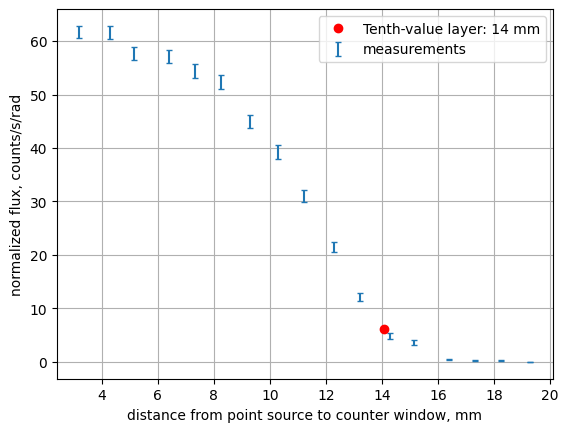

In [ ]:
data = '''
# shelf#, spacer#, time/s, counts,
# measured 21.11.2024 with spacers
2 0 10 3
2 1 10 6
2 2 10 7
2 3 10 10
2 4 10 66
2 5 10 93
2 6 10 247
2 7 10 472
2 8 10 743
2 9 10 1017
1 0 10 1268
1 1 10 1615
1 2 10 1817
1 3 10 2068
1 4 10 2322
1 5 10 2657
1 6 10 2903
'''

n, spacer, time, counts = np.loadtxt(data.splitlines(), unpack=True, dtype=int)
# distance from sourse to GM counter window
h = d0 + (n - 1) * di - shelf_thickness - sample_height - spacers_height[spacer]

# solid angle
omega = 2 * np.pi * (1 - 1 / np.sqrt(1 + (r / h)**2))
# rate
delta = 1 / np.sqrt(counts) # relative error
I = counts / time
I -= I_background # background correction (negligible)
I = I / (1 - I * tau) # system dead time correction (up to 5% increase at high rates)
# flux
flux = I / omega
flux_err = delta * flux

#interpolate to find TLV
f = interp1d(h, flux, kind='slinear', fill_value='extrapolate')
h_new = np.linspace(h.min(), h.max(), 100)
flux_new = f(h_new)
# find TLV
TVL = np.max(flux) / 10
h_TVL = fsolve(lambda x: f(x) - TVL, h_new.max())[0]

# plot
plt.errorbar(h, flux, yerr=flux_err, linestyle='', capsize=2, label='measurements');
#plt.plot(h_new, flux_new, color='lightgray', label='interpolation');
plt.plot(h_TVL, f(h_TVL), 'o', color='red', label=f'Tenth-value layer: {h_TVL:.0f} mm')
plt.xlabel('distance from point source to counter window, mm')
plt.ylabel('normalized flux, counts/s/rad')
plt.legend()
plt.grid();

In [ ]:
print(f'Observed range TLV: {h_TVL:.0f} mm + effective path in mica {h0:.0f} mm = {h_TVL +h0:.0f} ± {h0_err:.0f} mm')
print(f'Expected range for E = {E_alpha} MeV: {R:.0f} mm')

Observed range TLV: 14 mm + effective path in mica 18 mm = 32 ± 2 mm
Expected range for E = 5.3 MeV: 41 mm


**Conclusion**

Difference of about 10 mm between observed and expected range could be explained by additional distance that alpha particle travels inside GM counter before avalanche happens.

